# Loading Libraries


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')
from pandas_profiling import ProfileReport

In [2]:
os.chdir("A:\DATA\Imartics")
df=pd.read_csv("cars.csv")

In [3]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


# Data Inspection

In [4]:
dfp=ProfileReport(df,title="CARS")
dfp.to_notebook_iframe()

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df.shape

(19237, 18)

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,19237.0,4.557654e+07,936591.422799,20746880.0,45698374.0,45772308.0,45802036.0,45816654.0
Price,19237.0,1.855593e+04,190581.269684,1.0,5331.0,13172.0,22075.0,26307500.0
Prod. year,19237.0,2.010913e+03,5.668673,1939.0,2009.0,2012.0,2015.0,2020.0
Cylinders,19237.0,4.582991e+00,1.199933,1.0,4.0,4.0,4.0,16.0
Airbags,19237.0,6.582627e+00,4.320168,0.0,4.0,6.0,12.0,16.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

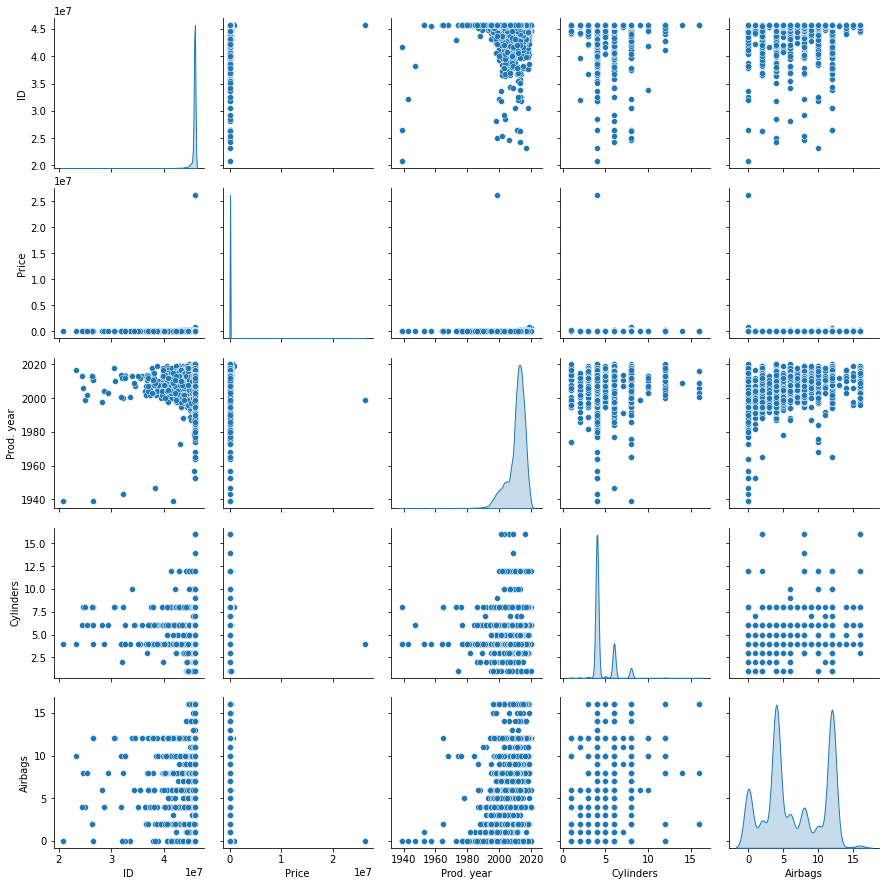

In [8]:
sns.pairplot(df, diag_kind='kde')

# Data Preprocessing

In [9]:
df.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [10]:
df.drop('ID',axis=1,inplace=True)

In [11]:
df['Levy']=df['Levy'].replace('-',np.nan)
df['Levy']=df['Levy'].astype(float)
levy_mean=0
df['Levy'].fillna(levy_mean,inplace=True)
df['Levy']=round(df['Levy'],2)

In [12]:
#since milage is in KM only we will remove 'km' from it and make it numerical
df['Mileage']=df['Mileage'].apply(lambda x:x.split(' ')[0])
df['Mileage']=df['Mileage'].astype('int')

In [13]:
df['Turbo']=df['Engine volume'].apply(lambda x:1 if 'Turbo' in str(x) else 0)
df['Engine volume']=df['Engine volume'].apply(lambda x:str(x).replace('Turbo',''))
df['Engine volume']=df['Engine volume'].astype(float)

In [14]:
df['Doors'].unique()

array(['04-May', '02-Mar', '>5'], dtype=object)

In [15]:
df.head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo
0,13328,1399.0,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,04-May,Left wheel,Silver,12,0
1,16621,1018.0,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8,0
2,8467,0.0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,04-May,Right-hand drive,Black,2,0
3,3607,862.0,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,04-May,Left wheel,White,0,0
4,11726,446.0,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,04-May,Left wheel,Silver,4,0


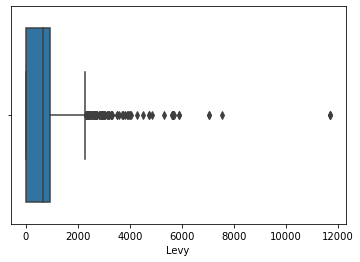

In [16]:
cols=['Levy','Engine volume', 'Mileage','Cylinders','Airbags']
sns.boxplot(df[cols[0]]);

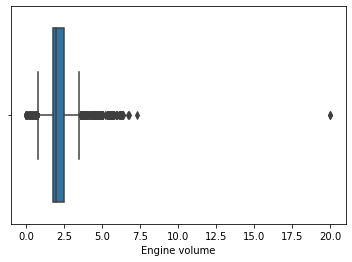

In [17]:
sns.boxplot(df[cols[1]]);

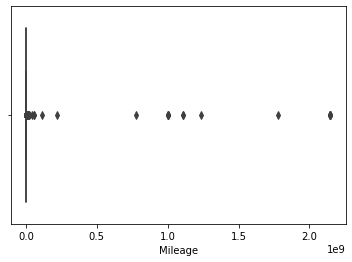

In [18]:
sns.boxplot(df[cols[2]]);

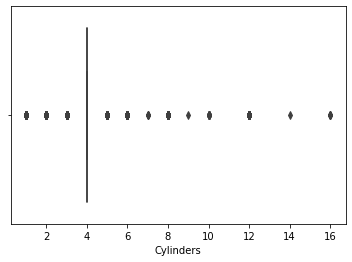

In [19]:
sns.boxplot(df[cols[3]]);

##### As we can see there are outliers in ‘Levy’,’Engine volume’, ‘Mileage’, ‘Cylinders’ columns. We will remove these outliers using Inter Quantile Range(IQR) method

In [20]:
def find_outliers_limit(df,col):
    print(col)
    print('-'*50)
    #removing outliers
    q25, q75 = np.percentile(df[col], 25), np.percentile(df[col], 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print('Lower:',lower,' Upper:',upper)
    return lower,upper

In [21]:
def remove_outlier(df,col,upper,lower):
    outliers = [x for x in df[col] if x ]
    print('Identified outliers: %d' % len(outliers))
    outliers_removed = [x for x in df[col] if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))
    final= np.where(df[col]>upper,upper,np.where(df[col]<lower,lower,df[col]))
    return final

outlier_cols=['Levy','Engine volume','Mileage','Cylinders']

for col in outlier_cols:
    lower,upper=find_outliers_limit(df,col)
    df[col]=remove_outlier(df,col,upper,lower)

Levy
--------------------------------------------------
Percentiles: 25th=0.000, 75th=917.000, IQR=917.000
Lower: -1375.5  Upper: 2292.5
Identified outliers: 13418
Non-outlier observations: 19076
Engine volume
--------------------------------------------------
Percentiles: 25th=1.800, 75th=2.500, IQR=0.700
Lower: 0.7500000000000002  Upper: 3.55
Identified outliers: 19227
Non-outlier observations: 17856
Mileage
--------------------------------------------------
Percentiles: 25th=70139.000, 75th=188888.000, IQR=118749.000
Lower: -107984.5  Upper: 367011.5
Identified outliers: 18516
Non-outlier observations: 18597
Cylinders
--------------------------------------------------
Percentiles: 25th=4.000, 75th=4.000, IQR=0.000
Lower: 4.0  Upper: 4.0
Identified outliers: 19237
Non-outlier observations: 14367


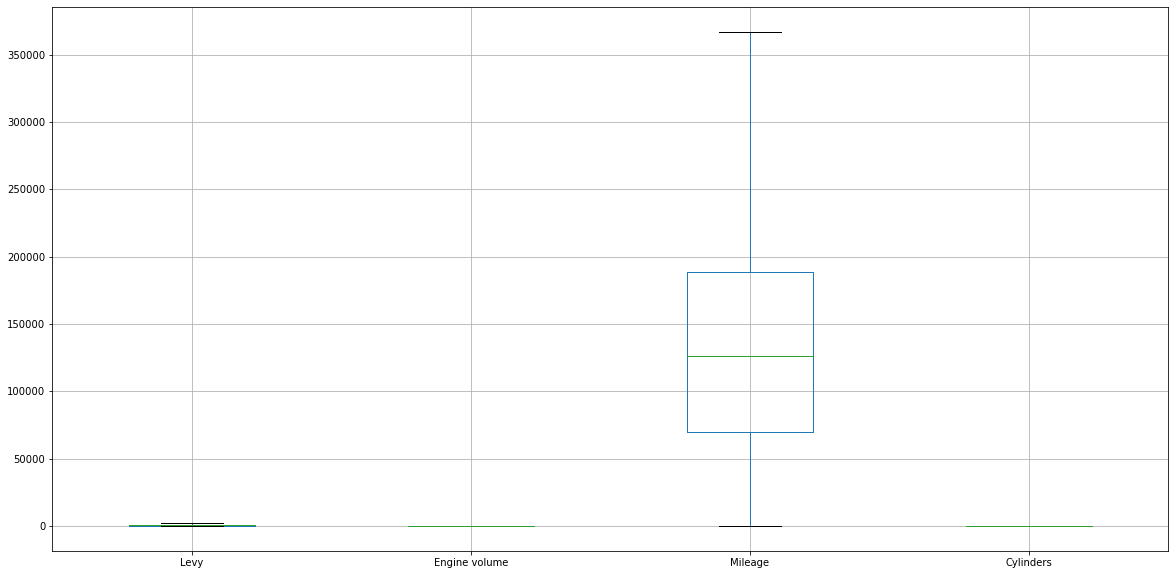

In [22]:
plt.figure(figsize=(20,10))
df[outlier_cols].boxplot()

## Creating Additional Features

In [23]:
labels=[0,1,2,3,4,5,6,7,8,9]
df['Mileage_bin']=pd.cut(df['Mileage'],len(labels),labels=labels)
df['Mileage_bin']=df['Mileage_bin'].astype(float)
labels=[0,1,2,3,4]
df['EV_bin']=pd.cut(df['Engine volume'],len(labels),labels=labels)
df['EV_bin']=df['EV_bin'].astype(float)

## Handling Categorical features

In [24]:
num_df=df.select_dtypes(include=np.number)
cat_df=df.select_dtypes(include=object)
encoding=OrdinalEncoder()
cat_cols=cat_df.columns.tolist()
encoding.fit(cat_df[cat_cols])
cat_oe=encoding.transform(cat_df[cat_cols])
cat_oe=pd.DataFrame(cat_oe,columns=cat_cols)
cat_df.reset_index(inplace=True,drop=True)
cat_oe.head()
num_df.reset_index(inplace=True,drop=True)
cat_oe.reset_index(inplace=True,drop=True)
final_all_df=pd.concat([num_df,cat_oe],axis=1)

In [25]:
final_all_df['price_log']=np.log(final_all_df['Price'])

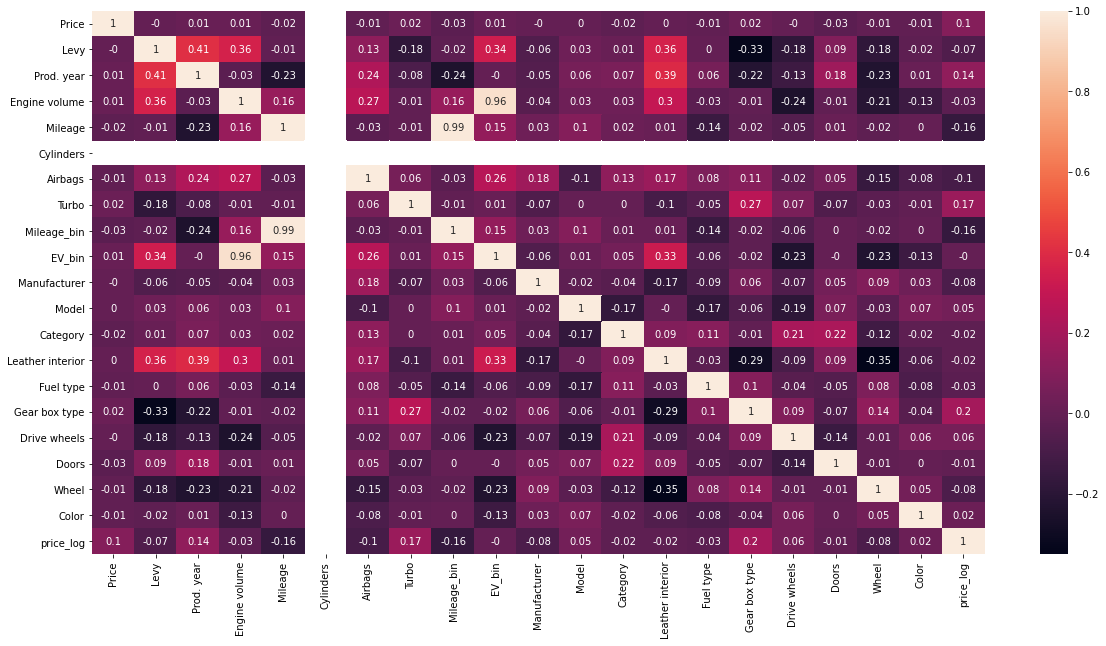

In [26]:
plt.figure(figsize=(20,10))
sns.heatmap(round(final_all_df.corr(),2),annot=True);

### Data Splitting and Scaling

In [27]:
cols_drop=['Price','price_log','Cylinders']
X=final_all_df.drop(cols_drop,axis=1)
y=final_all_df['Price']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=25)
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [28]:
X_train.head()

,Levy,Prod. year,Engine volume,Mileage,Airbags,Turbo,Mileage_bin,EV_bin,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
15679,0.0,1992,2.5,11111.0,0,1,0.0,3.0,39.0,1107.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,11.0
7384,0.0,2005,1.8,187323.0,6,0,5.0,1.0,36.0,571.0,9.0,1.0,0.0,0.0,2.0,1.0,0.0,12.0
13999,0.0,2012,3.0,123000.0,12,1,3.0,4.0,36.0,990.0,4.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0
13927,0.0,2009,1.6,21900.0,4,0,0.0,1.0,53.0,1069.0,3.0,0.0,5.0,1.0,1.0,1.0,0.0,12.0
1048,0.0,2011,1.8,0.0,12,0,0.0,1.0,58.0,1154.0,9.0,0.0,2.0,0.0,1.0,1.0,0.0,11.0


## Model Building

In [29]:
def train_ml_model(x,y,model_type):
    if model_type=='lr':
        model=LinearRegression()
    elif model_type=='xgb':
        model=XGBRegressor()
    elif model_type=='rf':
        model=RandomForestRegressor()
    model.fit(X_train_scaled,np.log(y))
    return model

In [30]:
def model_evaluate(model,x,y):
    predictions=model.predict(x)
    predictions=np.exp(predictions)
    mse=mean_squared_error(y,predictions)
    mae=mean_absolute_error(y,predictions)
    mape=mean_absolute_percentage_error(y,predictions)
    msle=mean_squared_log_error(y,predictions)
    mse=round(mse,2)
    mae=round(mae,2)
    mape=round(mape,2)
    msle=round(msle,2)
    return [mse,mae,mape,msle]

model_lr=train_ml_model(X_train_scaled,y_train,'lr')
model_xgb=train_ml_model(X_train_scaled,y_train,'xgb')
model_rf=train_ml_model(X_train_scaled,y_train,'rf')

In [31]:
model_dl_small=Sequential()
model_dl_small.add(Dense(16,input_dim=X_train_scaled.shape[1],activation='relu'))
model_dl_small.add(Dense(8,activation='relu'))
model_dl_small.add(Dense(4,activation='relu'))
model_dl_small.add(Dense(1,activation='linear'))
model_dl_small.compile(loss='mean_squared_error',optimizer='adam')

In [32]:
model_dl_small.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                304       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [33]:
epochs=20
batch_size=10
model_dl_small.fit(X_train_scaled,np.log(y_train),verbose=0,validation_data=(X_test_scaled,np.log(y_test)),epochs=epochs,batch_size=batch_size)

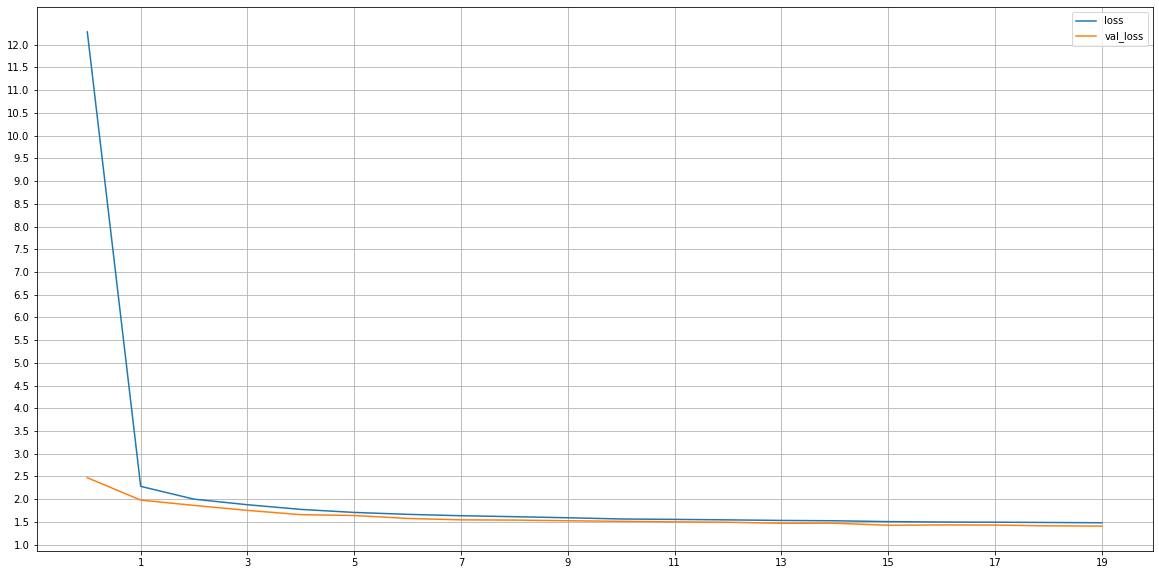

In [34]:
history_df = pd.DataFrame(model_dl_small.history.history)
plt.figure(figsize=(20,10))
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='val_loss')
plt.xticks(np.arange(1,epochs+1,2))
plt.yticks(np.arange(1,max(history_df['loss']),0.5))
plt.legend()
plt.grid()

In [35]:
model_dl_large=Sequential()
model_dl_large.add(Dense(64,input_dim=X_train_scaled.shape[1],activation='relu'))
model_dl_large.add(Dense(32,activation='relu'))
model_dl_large.add(Dense(16,activation='relu'))
model_dl_large.add(Dense(1,activation='linear'))
model_dl_large.compile(loss='mean_squared_error',optimizer='adam')
model_dl_large.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1216      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________


In [36]:
epochs=20

batch_size=10

model_dl_large.fit(X_train_scaled,np.log(y_train),verbose=0,validation_data=(X_test_scaled,np.log(y_test)),epochs=epochs,batch_size=batch_size)

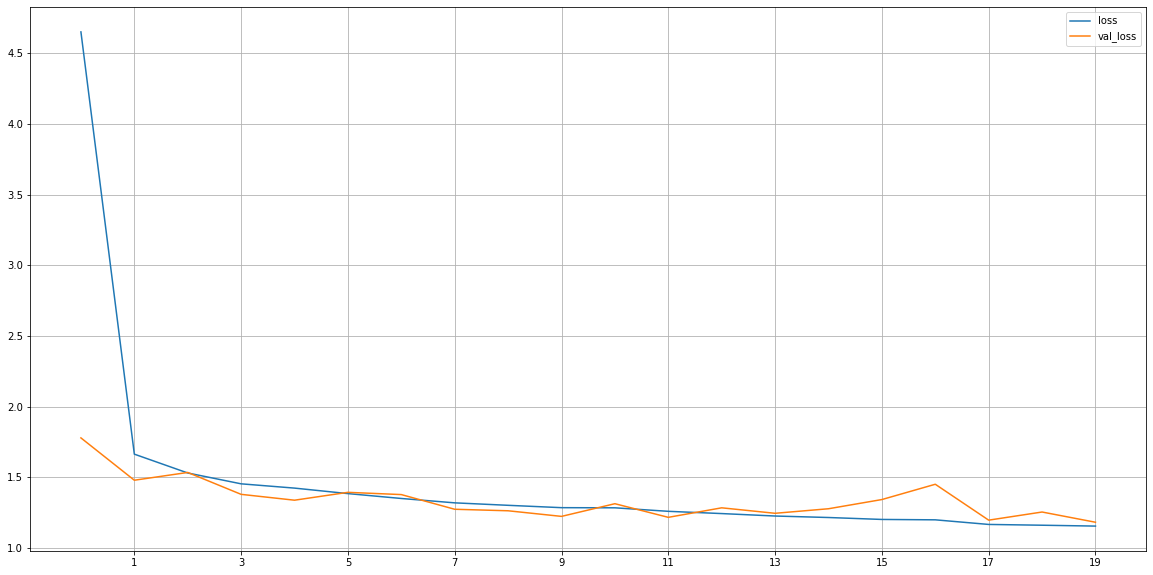

In [37]:
history_df = pd.DataFrame(model_dl_large.history.history)
plt.figure(figsize=(20,10))
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='val_loss')
plt.xticks(np.arange(1,epochs+1,2))
plt.yticks(np.arange(1,max(history_df['loss']),0.5))
plt.legend()
plt.grid()

## Model Performance
We have evaluated the models using Mean_Squared_Error, Mean_Absolute_Error, Mean_Absolute_Percentage_Error, Mean_Squared_Log_Error as performance matrices, and below are the results we got.

In [38]:
summary=PrettyTable(['Model','MSE','MAE','MAPE','MSLE'])
summary.add_row(['LR']+model_evaluate(model_lr,X_test_scaled,y_test))
summary.add_row(['XGB']+model_evaluate(model_xgb,X_test_scaled,y_test))
summary.add_row(['RF']+model_evaluate(model_rf,X_test_scaled,y_test))
summary.add_row(['DL_SMALL']+model_evaluate(model_dl_small,X_test_scaled,y_test))
summary.add_row(['DL_LARGE']+model_evaluate(model_dl_large,X_test_scaled,y_test))
print(summary)

+----------+--------------+----------+------+------+
|  Model   |     MSE      |   MAE    | MAPE | MSLE |
+----------+--------------+----------+------+------+
|    LR    | 337217465.57 | 11117.14 | 6.88 | 2.04 |
|   XGB    | 195254474.28 | 6282.57  | 3.87 | 0.88 |
|    RF    | 114064308.15 | 4662.55  | 3.17 | 0.81 |
| DL_SMALL | 214638510.32 | 8038.98  | 4.72 | 1.4  |
| DL_LARGE | 172782470.01 |  7095.1  | 4.81 | 1.18 |
+----------+--------------+----------+------+------+


In [39]:
y_pred=np.exp(model_rf.predict(X_test_scaled))

In [40]:
number_of_observations=20
x_ax = range(len(y_test[:number_of_observations]))

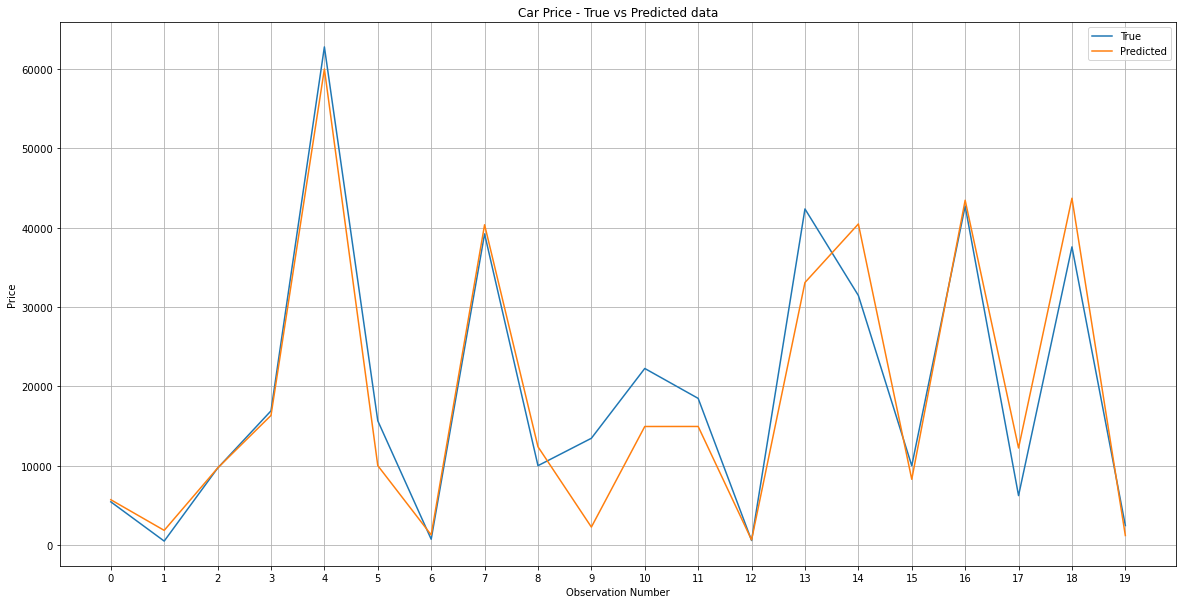

In [41]:
plt.figure(figsize=(20,10))
plt.plot(x_ax, y_test[:number_of_observations], label="True")
plt.plot(x_ax, y_pred[:number_of_observations], label="Predicted")
plt.title("Car Price - True vs Predicted data")
plt.xlabel('Observation Number')
plt.ylabel('Price')
plt.xticks(np.arange(number_of_observations))
plt.legend()
plt.grid()
plt.show()

### Conclusion
In this article, we tried predicting the car price using the various parameters that were provided in the data about the car. We build machine learning and deep learning models to predict car prices and saw that machine learning-based models performed well at this data than deep learning-based models.